# Neural Network from Scratch in Python

In [1]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
import numpy as np
from typing import List
import matplotlib.pyplot as plt

## 1 Layer, 1 Neuron Neural Network, OR logic gate
What goes on inside a perceptron?

$z = \mathbf{w} \cdot \mathbf{x} + b = w_0x_0 + w_1x_1 + b$

We introduce non-linearity to the system using the sigmoid function i.e.
$a = \sigma(z) = \frac{1}{1+e^{-z}}$

### Backpropagation
The problem regards how we actually update the weights of each neuron in the system. A common method utilises what is called the _gradient descent_ algorithm.
This involves updating the weights of each neuron, every epoch we train the model. A hyperparameter $\eta$ is introduced which is commonly called the _learning rate_ (LR) or occassionally _mixing parameter_.

$
\begin{equation}
\mathbf{w}' = \mathbf{w} - \eta \frac{\partial E}{\partial \mathbf{w}}
\end{equation}
$

We use the chain rule to solve $\frac{\partial E}{\partial \mathbf{w}}$ i.e.
$\begin{equation}
\frac{\partial E}{\partial \mathbf{w}} = \frac{\partial E}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial \mathbf{w}}
\end{equation}$

Solving each term (assuming the Error Function is MSE here and activation function is sigmoid in this case):
$\begin{equation}
\frac{\partial E}{\partial a} = \frac{\partial}{\partial a}\frac{1}{2} (y - a)^2 = a - y
\end{equation}$

$\begin{equation}
\frac{\partial a}{\partial z} = \frac{\partial}{\partial z}\sigma(z) = \sigma(z)(1 - \sigma(z))
\end{equation}$

$\begin{equation}
\frac{\partial z}{\partial \mathbf{w}} = \frac{\partial}{\partial \mathbf{w}} \mathbf{w} \cdot \mathbf{x} + b = \mathbf{x}
\end{equation}$

which finally gives us

$\begin{equation}
\frac{\partial E}{\partial \mathbf{w}} = (a - y) \times \sigma(z)(1 - \sigma(z)) \times \mathbf{x}
\end{equation}$

and finally what about the bias?

$\begin{equation}
\frac{\partial E}{\partial b} = \frac{\partial E}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial b}
\end{equation}$

We know most of these terms except the last

$\begin{equation}
\frac{\partial z}{\partial b} = \frac{\partial}{\partial b} \mathbf{w} \cdot \mathbf{x} + b = 1
\end{equation}$

and so, finally

$\begin{equation}
\frac{\partial E}{\partial b} = (a - y) \times \sigma(z)(1 - \sigma(z))
\end{equation}$

In [2]:
class ActivationFunction(ABC):
    @abstractmethod
    def function(self):
        pass

    @abstractmethod
    def derivative(self):
        pass

class ErrorFunction(ABC):
    @abstractmethod
    def function(self):
        pass

    def derivative(self):
        pass

In [320]:

@dataclass
class Sigmoid(ActivationFunction):
    name: str = 'sigmoid'

    def function(self, x):
        return 1/(1 + np.exp(-x))
    
    def derivative(self, x):
        return self.function(x)*(1-self.function(x))
    
@dataclass 
class MeanSquaredError(ErrorFunction):
    name: str = 'MSE'

    def function(self, a, y):
        return 0.5*(y - a)**2
    
    def derivative(self, a, y):
        return (a - y)

@dataclass
class Neuron():
    input_shape: int
    activation_function: ActivationFunction
    weights: np.ndarray[np.float64] = None
    bias: float = np.random.rand()
    error: float = 0
    delta: np.ndarray = np.array([])
    delta_weights: np.ndarray = np.array([])
    z: float = None
    a: float = None

    def __post_init__(self):
        """Initialise the weights. We do this post_initialisation because we depend
        on the input shape.
        """
        self.weights = np.random.rand(self.input_shape)

    def forward(self, x: np.ndarray) -> float:
        self.inputs = x
        self.z = np.dot(self.weights, x) + self.bias
        self.a = self.activation_function.function(self.z)

        return self.a
    
    def backward(self, delta: np.ndarray):
        self.error = delta * self.activation_function.derivative(self.z)

        return self.error
    
    def append_errors(self, previous_output):
        self.delta = np.append(self.delta, self.error)
        self.delta_weights = np.append(self.delta_weights, np.outer(self.error, previous_output))
    
    def update_weights(self, lr=0.05):
        self.weights -= (lr/4) * np.mean(self.delta_weights)
        self.bias -= (lr/4) * np.mean(self.delta)
        self.delta_weights = np.array([])
        self.delta = np.array([])


In [56]:
X = [[0, 0], [0, 1], [1, 0], [1, 1]]
Y = [0, 1, 1, 1]

In [58]:
n1 = Neuron(2, Sigmoid())
for x, y in zip(X, Y):
    x = np.array(x)
    y = np.array(y)

    a = n1.forward(x)
    E = 0.5*(y - a)**2
    E_prime = (a - y)

print(E_prime)

-0.14371635272559125


In [60]:
n1.input_shape

2

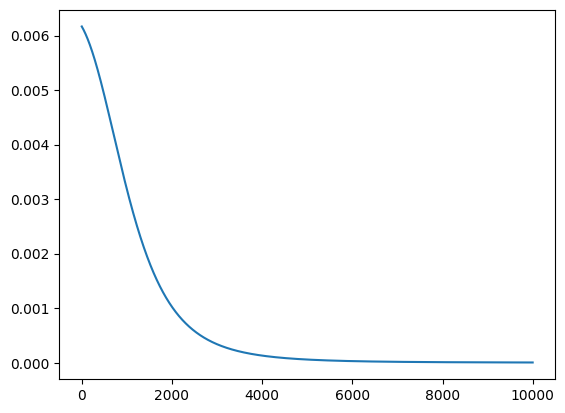

In [33]:
n1 = Neuron(2, Sigmoid())
all_E = []
for i in range(10000):
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)

        a = n1.forward(x)
        E = 0.5*(y - a)**2
        E_prime = (a - y)
        delta = n1.backward(E_prime, x)

        n1.update_weights()
    all_E += [E]

plt.figure()
plt.plot(all_E)
plt.show()

In [61]:
n0 = Neuron(2, Sigmoid())
n1 = Neuron(1, Sigmoid())
all_E = []
for i in range(100000):
    E = 0
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)

        a0 = n0.forward(x)
        a1 = n1.forward(a0)
        E += 0.5*(y - a1)**2
        E_prime = (a1 - y)
        d1 = n1.backward(E_prime, n0.a)
        d0 = n0.backward(d1, x)

    n1.update_weights()
    n0.update_weights()
    all_E += [E]

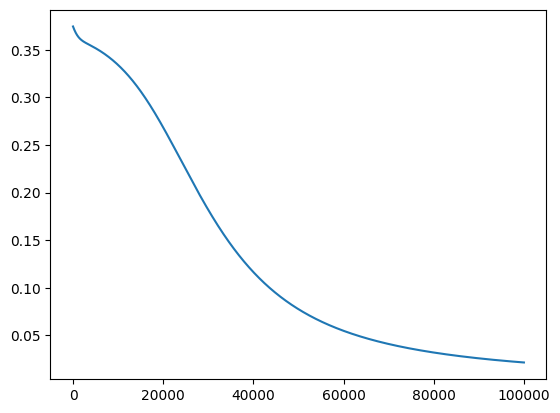

In [36]:
plt.figure()
plt.plot(all_E)
plt.show()

In [365]:
@dataclass
class Layer():
    num_neurons: int
    activation: ActivationFunction
    input_shape: np.ndarray = None
    neurons: List[Neuron] = None
    inputs: np.ndarray = None
    z: np.ndarray[float] = None
    a: np.ndarray[float] = None

    def __post_init__(self):
        if self.input_shape is not None:
            self.initialise_layer()

    def __call__(self, layer):
        self.input_shape = layer.num_neurons
        self.initialise_layer()
        return self
    
    def initialise_layer(self):
        self.neurons = [Neuron(self.input_shape, self.activation) for _ in range(self.num_neurons)]

    def forward(self, x):
        self.inputs = x
        for n in self.neurons: n.forward(x)
        self.z = [n.z for n in self.neurons]
        self.a = [n.a for n in self.neurons]
        return self.a
    
    def backward(self, layerp1):
        error = compute_error_term(self, layerp1)
        [n.backward(e) for n, e in zip(self.neurons, error)]

def compute_error_term(layer, layerp1):
    error = np.zeros(len(layer.neurons))
    for i in range(len(layer.neurons)):
        for j in range(len(layerp1.neurons)):
            error[i] += layerp1.neurons[j].weights[i] * layerp1.neurons[j].error # compute the dot product iteratively.
    
    return error

In [385]:
l0 = Layer(5, Sigmoid(), 2)
print(l0)
l1 = Layer(2, Sigmoid())(l0)
print(l1)
output = Layer(1, Sigmoid())(l1)
print(output)

x = np.array([0, 0])
y = np.array([0])

a0 = l0.forward(x)
a1 = l1.forward(a0)
o = output.forward(a1)

E = 0.5*(y - o)**2
E_prime = (o - y)

def compute_error_term(layer, layerp1):
    error = np.zeros(len(layer.neurons))
    for i in range(len(layer.neurons)):
        for j in range(len(layerp1.neurons)):
            error[i] += layerp1.neurons[j].weights[i] * layerp1.neurons[j].error # compute the dot product iteratively.
    
    return error


[n.backward(E_prime) for n in output.neurons]
#[n.backward(np.dot(np1.weights, np1.delta * np.ones_like(np1.weights)), a1) for n in l1.neurons for np1 in output.neurons]
#[n.backward(np.dot(np1.weights, np1.delta), a1) for n in l0.neurons for np1 in l1.neurons]
#print(output.neurons[0].delta)

Layer(num_neurons=5, activation=Sigmoid(name='sigmoid'), input_shape=2, neurons=[Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.21982991, 0.68849561]), bias=0.6605556812289234, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.09835255, 0.93055049]), bias=0.6605556812289234, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.93455499, 0.27234995]), bias=0.6605556812289234, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.88348776, 0.55879816]), bias=0.6605556812289234, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=No

[array([0.09757583])]

In [384]:
error = np.zeros(len(output.neurons))
for i in range(len(output.neurons)):
    for j in range(len(l1.neurons)):
        error[i] += l1.neurons[j].weights[i] * l1.neurons[j].error

In [383]:
l1.neurons[0].error

0

In [386]:
error = compute_error_term(l1, output)
[n.backward(e) for n, e in zip(l1.neurons, error)]

error = compute_error_term(l0, l1)
[n.backward(e) for n, e in zip(l0.neurons, error)]

[0.0010642757473972022,
 0.0010498952225788877,
 0.00019007016844851732,
 0.0014392760353869507,
 0.002047384183009872]

In [379]:
for n, d in zip(l1.neurons, compute_error_term(l1, output)):
    n.delta = d

for n, d in zip(l0.neurons, compute_error_term(l0, l1)):
    n.delta = d 

ValueError: setting an array element with a sequence.

In [131]:
delta = np.zeros(len(l0.neurons))
for i in range(len(l0.neurons)):
    for j in range(len(l1.neurons)):
        delta[i] += l1.neurons[j].weights[i] * l1.neurons[j].delta * l0.neurons[i].activation_function.derivative(l0.neurons[i].z)

In [128]:
delta

array([0.00221807, 0.00143975, 0.00327121, 0.00276309, 0.00317188])

In [115]:
l1.neurons[0].weights, l1.neurons[1].weights, l1.neurons[0].delta, l1.neurons[1].delta

(array([6.22929601e-04, 2.14468873e-02, 2.06496879e-01, 5.54261147e-01,
        7.21275646e-01]),
 array([0.65594126, 0.39985916, 0.71422085, 0.13552299, 0.05088261]),
 array([0.01834267]),
 array([0.01489506]))

In [100]:
w = np.random.uniform(0, 1, (5, 2))
d = np.random.uniform(0, 1, (2))

np.dot(w, d) * l0.z

array([0.73982256, 0.36266338, 0.72783426, 0.45592178, 0.68700517])

In [89]:
for n in l1.neurons:
    print(n.delta)

[0.01834267]
[0.01489506]


In [97]:
l1.neurons[1].weights, 

(array([0.65594126, 0.39985916, 0.71422085, 0.13552299, 0.05088261]),)

In [73]:
l1.neurons[0].delta, l1.neurons[1].delta

(array([0.00503387]), array([0.00947829]))

In [64]:
[n.backward(E_prime, a1) for n in output.neurons][0]

array([-0.00295756])

In [68]:
output.neurons[0].delta.dot(l1.neurons[0].weights)

ValueError: shapes (1,) and (5,) not aligned: 1 (dim 0) != 5 (dim 0)

In [54]:
output.neurons[0].delta

array([0.09922206, 0.09922206])

In [21]:
def backward(self, delta: np.ndarray, prev_output: np.ndarray):
    delta = delta * self.activation_function.derivative(self.z)
    self.delta = np.append(self.delta, delta)
    self.delta_weights = np.append(self.delta_weights, np.outer(delta, prev_output))

    return delta

In [16]:
delta_

Neuron(input_shape=5, activation_function=Sigmoid(name='sigmoid'), weights=array([0.96578846, 0.05309858, 0.91412256, 0.60976378, 0.69162867]), bias=0.46596223615012256, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=2.453268214371623, a=0.9208001207518959)

In [ ]:
for i, n in enumerate(l1.neurons):
    delta = 0
    for j, np1 in enumerate(output.neurons):
        delta += np.dot(np.expand_dims(np1.weights, axis=-1), delta_L) + n.activation_function.derivative(n.z)

In [ ]:
delta

In [ ]:
np.dot(l1.neurons[0].weights, np.array([0.00380112, 0.00581371]))

In [ ]:
np.expand_dims(output.neurons[0].weights, axis=-1).T

In [ ]:
output.

In [ ]:
np.dot(output.neurons[0].weights.T, output.neurons[0].delta)

In [ ]:
    def backward(self, delta_Lp1: np.ndarray, w_Lp1: np.ndarray, prev_output: np.ndarray):
        delta = np.dot(w_Lp1.T, delta_Lp1) * self.activation_function.derivative(self.z)
        self.delta = np.append(self.delta, delta)
        self.delta_weights = np.append(self.delta_weights, np.outer(delta, prev_output))

        return delta

In [ ]:
l1.neurons[0]

In [ ]:
output.neurons[0].delta * output.neurons[0].weights[0] * l1.neurons[0].activation_function.derivative(l1.neurons[0].z)

In [ ]:
for j in range(len(output.neurons)):
    for k in range(len(l1.neurons)):
        l1.neurons[k].delta = l1.neurons[k].backward(output.neurons[j].delta, output.neurons[j].weights[k])

In [ ]:
output.delta = delta_L
l1.delta = np.vstack([np.dot(n.weights, delta) * n.activation_function.derivative(n.z) for n in output.neurons])
l0.delta = np.vstack([np.dot(n.weights, delta) * n.activation_function.derivative(n.z) for n in l1.neurons])

In [ ]:
l0_delta = []
l1_delta = []
for x, y in zip(X, Y):
    x = np.array(x)
    y = np.array(y)

    a0 = l0.forward(x)
    a1 = l1.forward(a0)
    o = output.forward(a1)

    E = 0.5*(y - o)**2
    E_prime = (o - y)

    delta_L = E_prime * output.neurons[0].activation_function.derivative(
        output.neurons[0].z
        )
    
    output.neurons[0].delta = delta_L
    
    for j in range(len(output.neurons)):
        for k in range(len(l1.neurons)):
            #l1.neurons[k].delta = l1.neurons[k].backward(output.neurons[j].delta, output.neurons[j].weights[k])
            l1_delta += [l1.neurons[k].backward(output.neurons[j].delta, output.neurons[j].weights[k])]

    for j in range(len(l1.neurons)):
        for k in range(len(l0.neurons)):
            l0.neurons[k].delta = l0.neurons[k].backward(l1.neurons[j].delta, l1.neurons[j].weights[k])

print(l1_delta)

In [ ]:
l1_delta

In [ ]:
l1.neurons[k].backward(output.neurons[j].delta, output.neurons[j].weights[k])

In [ ]:
output.neurons[0].weights.transpose() * delta_L * l1.neurons[0].activation_function.derivative(np.dot(l1.neurons[0].weights, l1.neurons[0].inputs) + l1.neurons[0].bias)

In [ ]:
np.dot(output.neurons[0].weights, delta[0])

In [ ]:
delta